# Credit Card Fraud Detection

In [33]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score , precision_score , recall_score , f1_score,roc_curve, auc


import warnings
warnings.filterwarnings('ignore')
sns.set_theme(color_codes=True)


In [9]:
df = pd.read_csv('./fraudTest.csv', on_bad_lines='skip')

In [8]:
df.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [10]:
def segment(row):
  if row['amt'] >100:
    return 'High'
  elif row['amt']>50:
    return 'Medium'
  else:
    return 'Low'

df['amt_segment'] = df.apply(segment,axis=1)

# print(df.head())
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['transaction_hour'] = df['trans_date_trans_time'].dt.hour

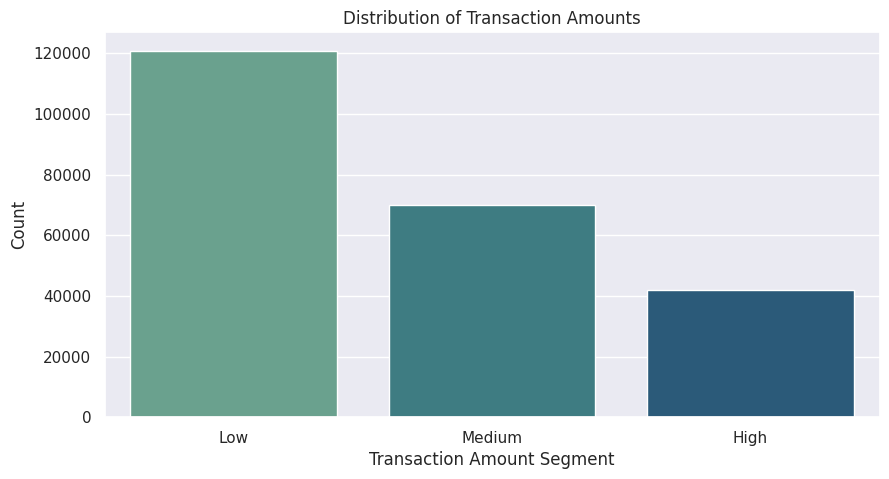

In [17]:
plt.figure(figsize=(10,5))
sns.countplot(x='amt_segment',data=df,palette='crest')
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Transaction Amount Segment')
plt.ylabel('Count')
plt.show()

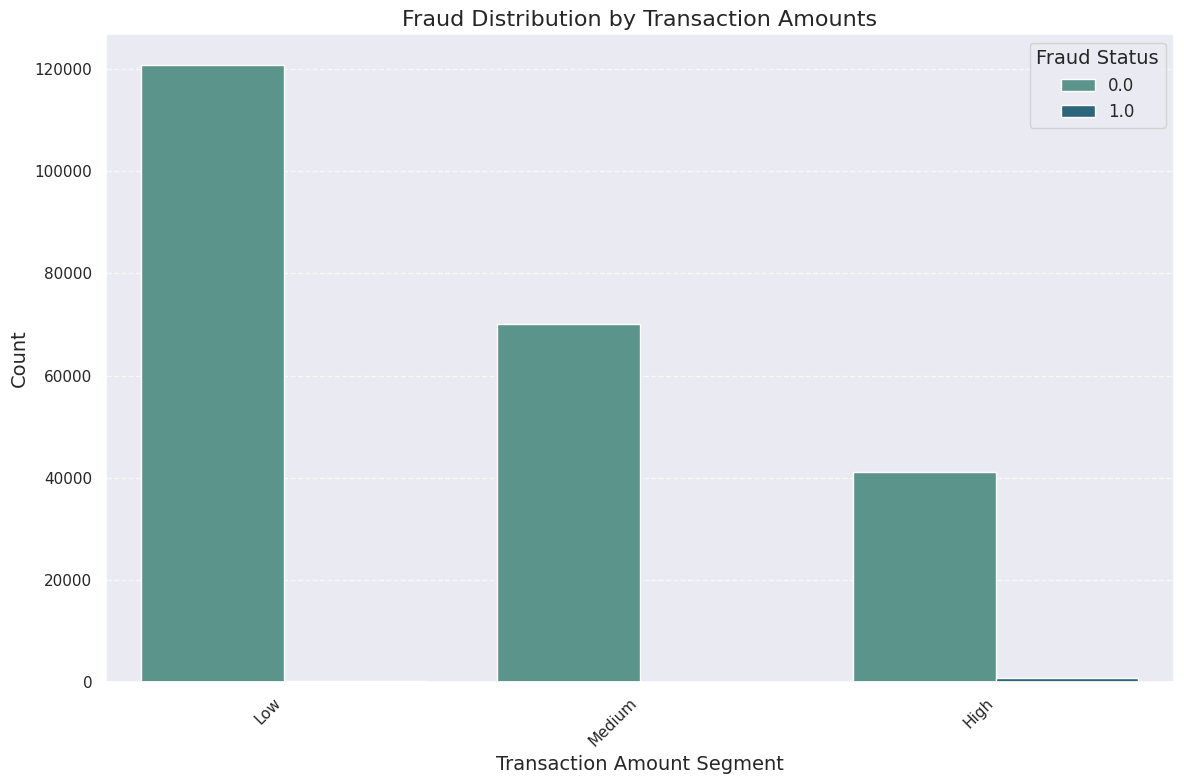

In [16]:
plt.figure(figsize=(12, 8))
sns.countplot(x='amt_segment', hue='is_fraud', data=df, palette='crest', dodge=True)
plt.title('Fraud Distribution by Transaction Amounts', fontsize=16)
plt.xlabel('Transaction Amount Segment', fontsize=14)
plt.ylabel('Count', fontsize=14)

plt.xticks(rotation=45, ha='right')

plt.legend(title='Fraud Status', loc='upper right', fontsize=12, title_fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

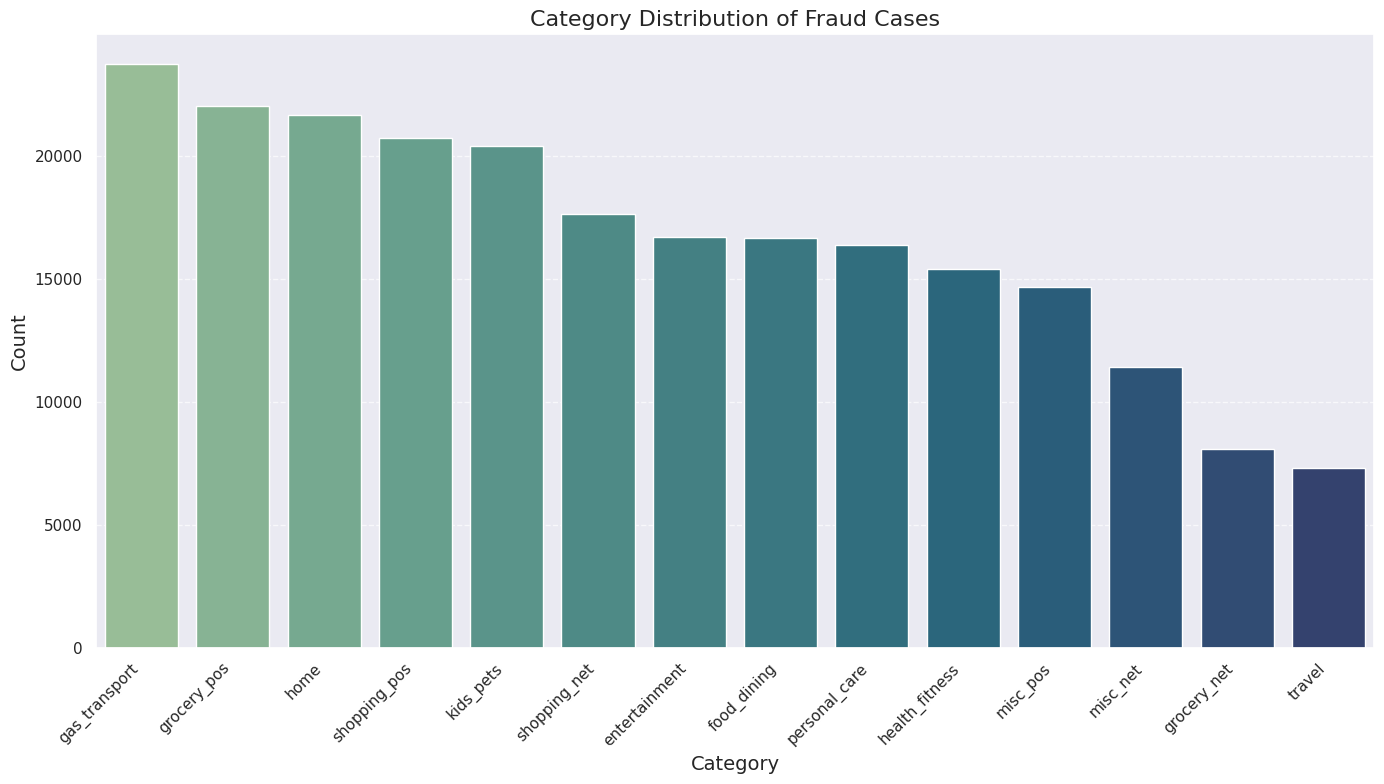

In [19]:
plt.figure(figsize=(14, 8))
sns.countplot(x='category', data=df, palette='crest', order=df['category'].value_counts().index)
plt.title('Category Distribution of Fraud Cases', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

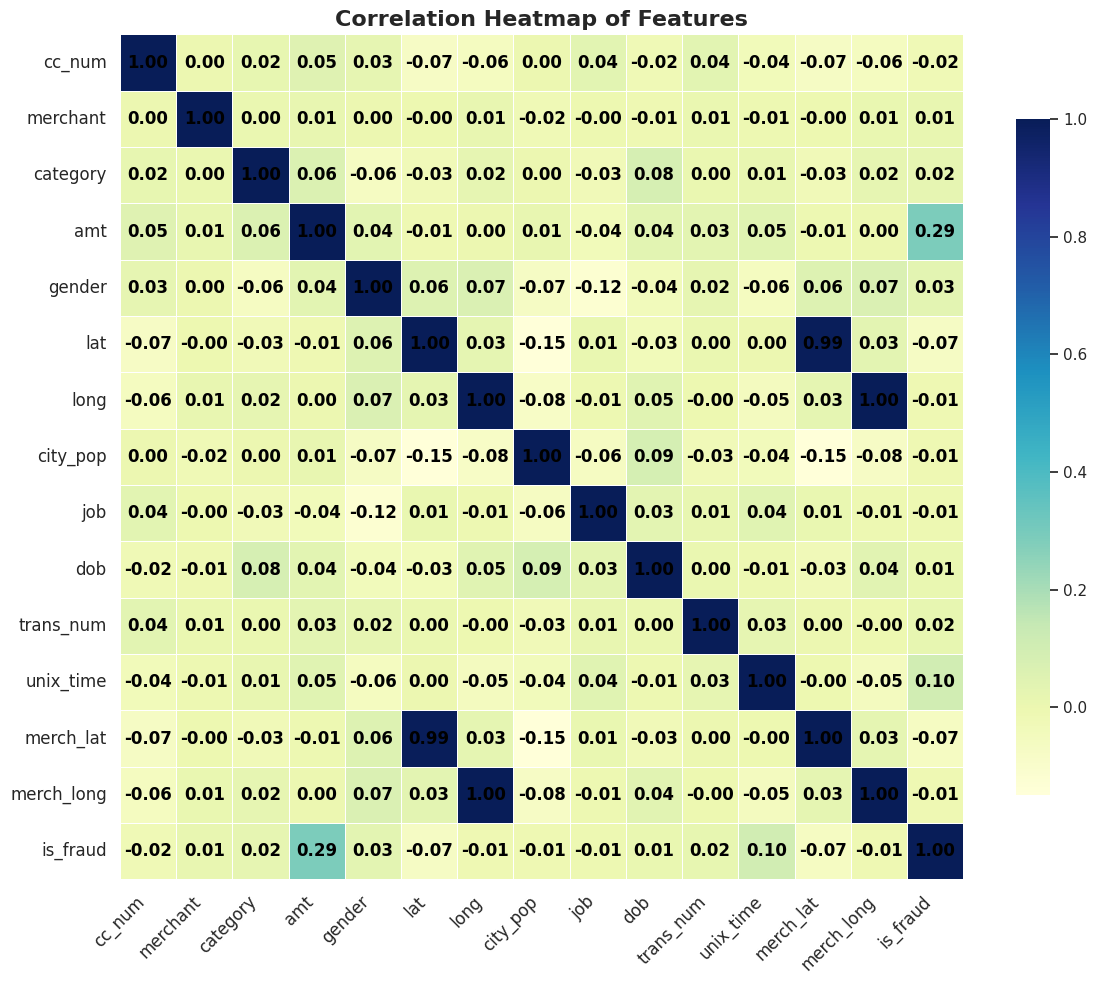

In [27]:
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=0.5,
            annot_kws={"size": 12, "weight": "bold", 'color': 'black'}, cbar_kws={'shrink': 0.8})
plt.title('Correlation Heatmap of Features', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [20]:
df= pd.read_csv('./fraudTest.csv' ,on_bad_lines='skip')

df=df.head(2000)
print(df.head())
print(df.info())
print(df.describe())

for column in df.columns:
  if df[column].dtype in ['int64','float64']:
    df[column].fillna(df[column].mean(),inplace=True)
  else:
    df[column].fillna(df[column].mode()[0],inplace=True)

label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
  le = LabelEncoder()
  df[column] = le.fit_transform(df[column])
  label_encoders[column] = le

df= df.drop(columns=['Unnamed: 0','trans_date_trans_time', 'first', 'last', 'street','city', 'state','zip'])

x= df.drop(columns=['is_fraud'])
y= df['is_fraud']

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

scaler= StandardScaler()
x_train= scaler.fit_transform(x_train)
x_test= scaler.transform(x_test)



   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2020-06-21 12:14:25  2291163933867244   
1           1   2020-06-21 12:14:33  3573030041201292   
2           2   2020-06-21 12:14:53  3598215285024754   
3           3   2020-06-21 12:15:15  3591919803438423   
4           4   2020-06-21 12:15:17  3526826139003047   

                               merchant        category    amt   first  \
0                 fraud_Kirlin and Sons   personal_care   2.86    Jeff   
1                  fraud_Sporer-Keebler   personal_care  29.84  Joanne   
2  fraud_Swaniawski, Nitzsche and Welch  health_fitness  41.28  Ashley   
3                     fraud_Haley Group        misc_pos  60.05   Brian   
4                 fraud_Johnston-Casper          travel   3.19  Nathan   

       last gender                       street  ...      lat      long  \
0   Elliott      M            351 Darlene Green  ...  33.9659  -80.9355   
1  Williams      F             3638 Marsh Union  ...  40.3207 

In [21]:
log_reg = LogisticRegression()
rf_clif = RandomForestClassifier()
gb_clif = GradientBoostingClassifier()


log_reg.fit(x_train,y_train)
rf_clif.fit(x_train,y_train)
gb_clif.fit(x_train,y_train)

models= [log_reg,rf_clif,gb_clif]
model_names= ['Logistic Regression','Random Forest','Gradient Boosting']

for model, name in zip(models,model_names):
  scores = cross_val_score(model,x_train,y_train,cv=5,scoring='roc_auc')
  print(f'{name} ROC-AUC : {scores.mean():.2f} +/- {scores.std():.2f}')

def evaluate_model(model,x_test,y_test):
  y_pred = model.predict(x_test)
  y_prob = model.predict_proba(x_test)[:,1]
  accuracy = accuracy_score(y_test,y_pred)
  precision = precision_score(y_test,y_pred)
  recall = recall_score(y_test,y_pred)
  f1 = f1_score(y_test,y_pred)
  roc_auc = roc_auc_score(y_test,y_prob)
  return accuracy , precision , recall , f1, roc_auc

for model, name in zip(models,model_names):
  accuracy,precision,recall,f1,roc_auc = evaluate_model(model,x_test,y_test)
  print(f'{name}- Accuracy : {accuracy:.2f} , Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}')



Logistic Regression ROC-AUC : 0.95 +/- 0.06
Random Forest ROC-AUC : 0.84 +/- 0.22
Gradient Boosting ROC-AUC : 0.80 +/- 0.25
Logistic Regression- Accuracy : 0.99 , Precision: 0.00, Recall: 0.00, F1-Score: 0.00
Random Forest- Accuracy : 1.00 , Precision: 1.00, Recall: 0.50, F1-Score: 0.67
Gradient Boosting- Accuracy : 1.00 , Precision: 1.00, Recall: 0.50, F1-Score: 0.67


In [22]:
from sklearn.model_selection import GridSearchCV

param_grid_rf = { 'n_estimators': [100, 200],
                 'max_depth': [10,20,None],
                  'min_samples_split': [2,5,10]
                  }
grid_rf = GridSearchCV(rf_clif, param_grid_rf, cv=5, scoring='roc_auc')
grid_rf.fit(x_train, y_train)
print(f"Best parameters for Random Forest: {grid_rf.best_params_}")
print(f"Best ROC-AUC score for Random Forest: {grid_rf.best_score_:.2f}")

param_grid_gb = {
    "n_estimators": [100, 200],
    "learning_rate": [0.01, 0.2],
    "max_depth": [3, 5, 7],
}
grid_gb= GridSearchCV(gb_clif, param_grid_gb, cv=5, scoring='roc_auc')
grid_gb.fit(x_train, y_train)

print(f"Best parameters for Gradient Boosting: {grid_gb.best_params_}")
print(f"Best ROC-AUC score for Gradient Boosting: {grid_gb.best_score_:.2f}")

Best parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Best ROC-AUC score for Random Forest: 0.89
Best parameters for Gradient Boosting: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
Best ROC-AUC score for Gradient Boosting: 0.80


In [23]:
best_rf = grid_rf.best_estimator_
best_gb = grid_gb.best_estimator_

for model, name in zip([log_reg ,best_rf, best_gb], ['Logistic Regression',' Tuned Random Forest', 'Gradient Boosting']):
  accuracy,precision,recall,f1,roc_auc = evaluate_model(model,x_test,y_test)
  print(f'{name}- Accuracy : {accuracy:.2f} , Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}')

Logistic Regression- Accuracy : 0.99 , Precision: 0.00, Recall: 0.00, F1-Score: 0.00
 Tuned Random Forest- Accuracy : 1.00 , Precision: 1.00, Recall: 0.50, F1-Score: 0.67
Gradient Boosting- Accuracy : 1.00 , Precision: 1.00, Recall: 0.50, F1-Score: 0.67


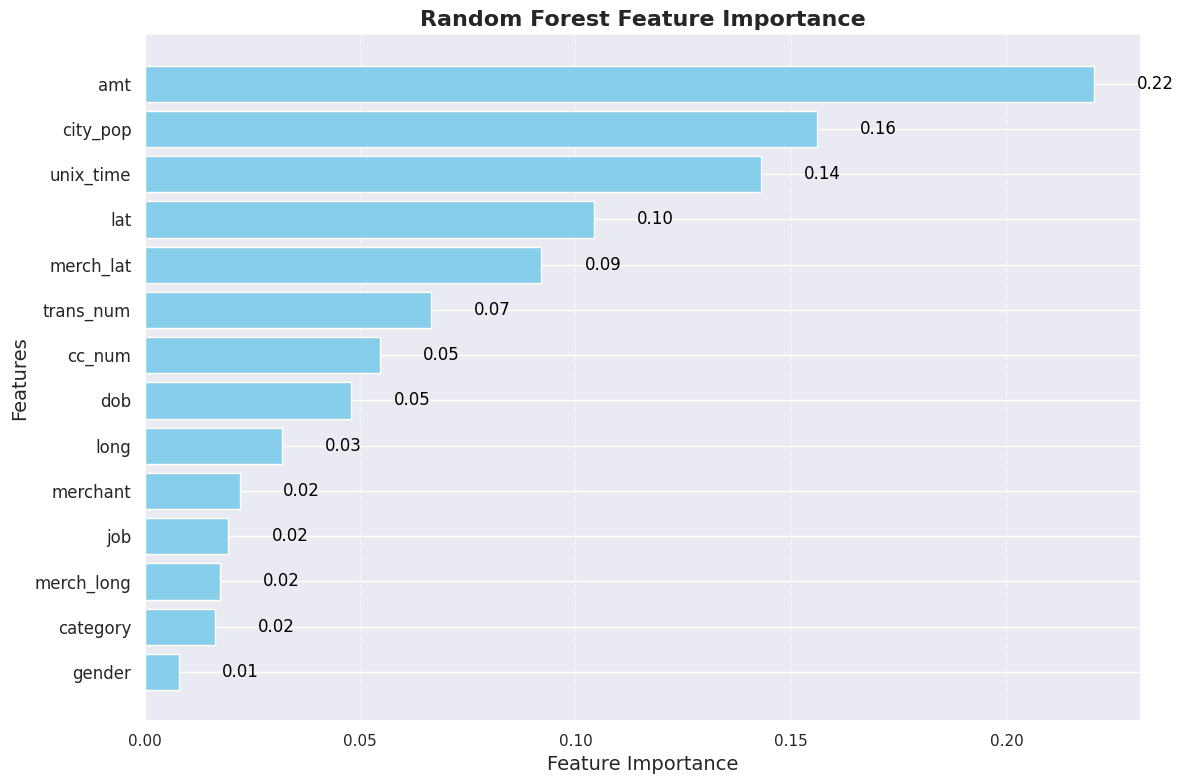

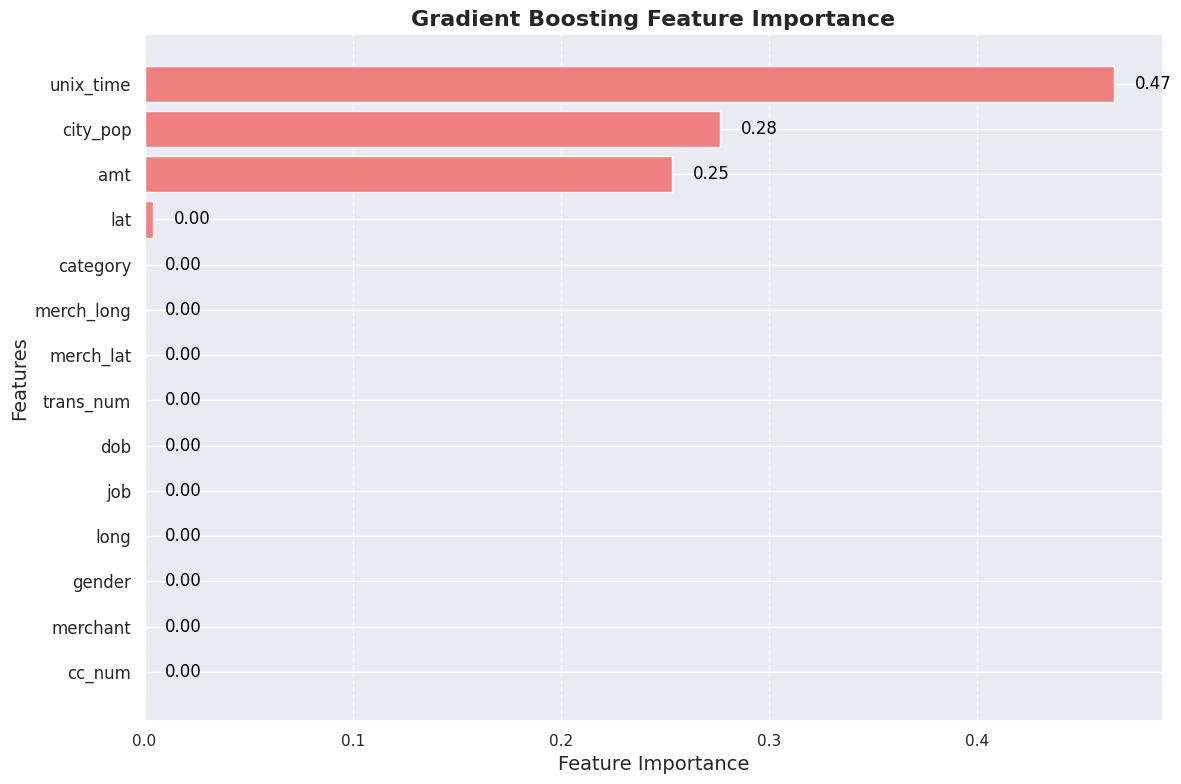

In [29]:
feature_importance_rf = best_rf.feature_importances_
sorted_idx_rf = np.argsort(feature_importance_rf)

plt.figure(figsize=(12, 8))  %
plt.barh(range(len(sorted_idx_rf)), feature_importance_rf[sorted_idx_rf], align='center', color='skyblue')
plt.yticks(range(len(sorted_idx_rf)), x.columns[sorted_idx_rf], fontsize=12)
plt.xlabel('Feature Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Random Forest Feature Importance', fontsize=16, fontweight='bold')
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
for i, v in enumerate(feature_importance_rf[sorted_idx_rf]):
    plt.text(v + 0.01, i, f'{v:.2f}', va='center', fontsize=12, color='black')
plt.tight_layout()
plt.show()

# Gradient Boosting Feature Importance
feature_importance_gb = best_gb.feature_importances_
sorted_idx_gb = np.argsort(feature_importance_gb)

plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_idx_gb)), feature_importance_gb[sorted_idx_gb], align='center', color='lightcoral')
plt.yticks(range(len(sorted_idx_gb)), x.columns[sorted_idx_gb], fontsize=12)
plt.xlabel('Feature Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Gradient Boosting Feature Importance', fontsize=16, fontweight='bold')
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
for i, v in enumerate(feature_importance_gb[sorted_idx_gb]):
    plt.text(v + 0.01, i, f'{v:.2f}', va='center', fontsize=12, color='black')
plt.tight_layout()
plt.show()

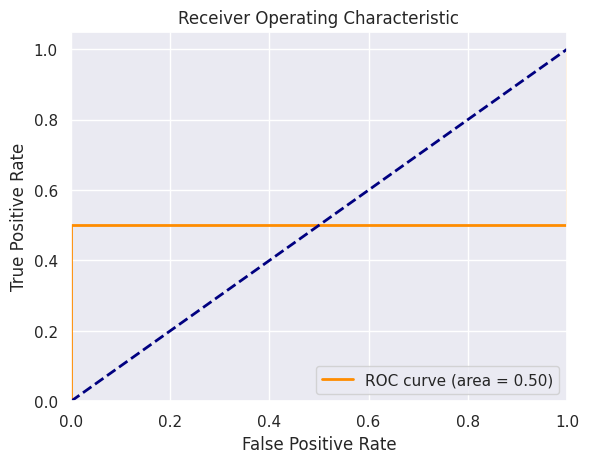

AUC: 0.5


In [34]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)